# GATWithTransformerFusion Training

This notebook demonstrates how to train the GATWithTransformerFusion model for end-to-end RNA to ADT mapping using a unified architecture that combines Graph Attention Networks (GAT) with Transformer fusion layers.

## Overview
1. Setup and imports
2. Load and preprocess data
3. Initialize GATWithTransformerFusion model
4. Train the model with end-to-end optimization
5. Evaluate performance
6. Save trained model
7. Make predictions on new data


## 1. Setup and Imports


In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add project root to Python path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("=== Setup Information ===")
print(f"Current directory: {current_dir}")
print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/an

=== Setup Information ===
Current directory: /projects/vanaja_lab/satya/DeepOMAPNet/Tutorials
Project root: /projects/vanaja_lab/satya/DeepOMAPNet
Python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA A100-SXM4-80GB
CUDA memory: 85.1 GB


In [2]:
import sys, os, importlib

# --- Paths ---
current_dir = os.getcwd()  # This will be .../DeepOMAPNet/Notebooks
project_root = os.path.dirname(current_dir)  # This will be .../DeepOMAPNet

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Added to Python path:")
print(f"- Current directory: {current_dir}")
print(f"- Project root: {project_root}")
print(f"- Scripts directory exists: {os.path.exists(os.path.join(project_root, 'scripts'))}")
print(f"- Scripts/data_provider exists: {os.path.exists(os.path.join(project_root, 'scripts', 'data_provider'))}")

# Clear any cached imports
importlib.invalidate_caches()

# --- Import modules (module-style, not from ... import ...) ---
import scripts.data_provider.data_preprocessing as data_preprocessing
import scripts.data_provider.graph_data_builder as graph_data_builder
import scripts.model.doNET as doNET
import scripts.trainer.gat_trainer as gat_trainer

print("Module imports successful!")

Added to Python path:
- Current directory: /projects/vanaja_lab/satya/DeepOMAPNet/Tutorials
- Project root: /projects/vanaja_lab/satya/DeepOMAPNet
- Scripts directory exists: True
- Scripts/data_provider exists: True
Module imports successful!


In [2]:
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
def clr_normalize(adata, axis=1, pseudo_count=1):
    
    print("Applying CLR normalization to ADT data...")
    
    # Make a copy to avoid modifying the original
    adata_clr = adata.copy()
    
    # Get raw counts (densify if sparse)
    X = adata_clr.X.toarray() if scipy.sparse.issparse(adata_clr.X) else adata_clr.X.copy()
    
    # Add pseudo count
    X += pseudo_count
    
    # Calculate geometric mean of each cell (row) or feature (column)
    if axis == 1:  # across features (for each cell)
        # Get geometric mean for each cell
        geometric_means = np.exp(np.mean(np.log(X), axis=1, keepdims=True))
        # CLR transformation
        X_clr = np.log(X / geometric_means)
    else:  # across cells (for each feature)
        # Get geometric mean for each feature
        geometric_means = np.exp(np.mean(np.log(X), axis=0, keepdims=True))
        # CLR transformation
        X_clr = np.log(X / geometric_means)
    
    # Update data
    adata_clr.X = X_clr
    
    # Store original data in raw slot
    adata_clr.raw = adata
    
    print(f"CLR normalization complete. Shape: {adata_clr.X.shape}")
    return adata_clr

## 2. Load and Preprocess Data


In [3]:
# Load training data
print("=== Loading Training Data ===")
# Load RNA and ADT data
rna_adata = sc.read_h5ad("/projects/vanaja_lab/satya/Datasets/GSMControlRNA.h5ad")
adt_adata = sc.read_h5ad("/projects/vanaja_lab/satya/Datasets/ControlADT.h5ad")


# Load the preprocessed data
from scripts.data_provider.data_preprocessing import prepare_train_test_anndata
data = prepare_train_test_anndata()
rna_adata = data[0]  # RNA data
adt_adata = data[2]   # ADT data



=== Loading Training Data ===
All sample IDs in gene data: ['AML0612' 'AML3762' 'AML3133' 'AML2910' 'AML3050' 'AML2451' 'AML056'
 'AML073' 'AML055' 'AML048' 'AML052' 'AML2123' 'AML1371' 'AML4340'
 'AML4897' 'AML051' 'AML0693' 'AML3948' 'AML3730' 'AML0160' 'AML0310'
 'AML0361' 'AML038' 'AML008' 'AML043' 'AML028' 'AML006' 'AML025' 'AML003'
 'AML012' 'AML005' 'AML0048' 'AML022' 'AML0024' 'AML009' 'AML026' 'AML001'
 'AML0114' 'Control4' 'Control2' 'Control1' 'Control3' 'Control5'
 'Control0004' 'Control0058' 'Control0082' 'Control4003' 'Control0005']
AML 80% train: ['AML0024', 'AML001', 'AML3050', 'AML4340', 'AML005', 'AML006', 'AML056', 'AML025', 'AML043', 'AML051', 'AML3948', 'AML055', 'AML0693', 'AML1371', 'AML0160', 'AML048', 'AML022', 'AML0612', 'AML028', 'AML2451', 'AML2123', 'AML3762', 'AML0114', 'AML0361', 'AML3133', 'AML012', 'AML026', 'AML2910', 'AML009', 'AML008', 'AML0048']
AML 20% test: ['AML052', 'AML038', 'AML3730', 'AML0310', 'AML073', 'AML4897', 'AML003']
Control 80% train

## 3. Convert to PyTorch Geometric Format


In [4]:
# Convert AnnData to PyTorch Geometric format
print("=== Converting to PyTorch Geometric Format ===")
from scripts.data_provider.graph_data_builder import build_pyg_data
# Convert RNA data
print("Converting RNA data...")
rna_pyg_data = build_pyg_data(rna_adata)
print(f"RNA PyG data: {rna_pyg_data}")

# Convert ADT data
print("Converting ADT data...")
adt_pyg_data = build_pyg_data(adt_adata)
print(f"ADT PyG data: {adt_pyg_data}")


if rna_pyg_data.num_nodes != adt_pyg_data.num_nodes:
    print("⚠️  Warning: RNA and ADT data have different number of nodes!")
else:
    print("✅ RNA and ADT data have same number of nodes")

print("✅ PyTorch Geometric conversion complete!")


=== Converting to PyTorch Geometric Format ===
Converting RNA data...
build_pyg_data called with use_pca=True
Input adata shape: (158179, 36601)
Available obsm keys: ['X_integrated.cca', 'X_pca', 'X_umap', 'X_umap.unintegrated']
Computing PCA with exactly 50 components...
PCA computed, shape: (158179, 50)
Computing neighbor graph first...
Computing leiden clusters first...
Using PCA features, shape: (158179, 50)
RNA PyG data: Data(x=[158179, 50], edge_index=[2, 1677806], y=[158179])
Converting ADT data...
build_pyg_data called with use_pca=True
Input adata shape: (158179, 279)
Available obsm keys: []
Computing PCA with exactly 50 components...
PCA computed, shape: (158179, 50)
Computing neighbor graph first...
Computing leiden clusters first...
Using PCA features, shape: (158179, 50)
ADT PyG data: Data(x=[158179, 50], edge_index=[2, 1768641], y=[158179])
✅ RNA and ADT data have same number of nodes
✅ PyTorch Geometric conversion complete!


In [13]:
rna_adata.shape[1]

36601

## 4. Initialize GATWithTransformerFusion Model


## 5. Train the Model


In [5]:
%load_ext autoreload
%autoreload 2
import importlib
import time
from datetime import datetime
from scripts.trainer import gat_trainer

# Reload the module
importlib.reload(gat_trainer)

# Re-import the functions you need
from scripts.trainer.gat_trainer import train_gat_transformer_fusion

print("=== Training Enhanced GATWithTransformerFusion Model ===")

# Training parameters (only parameters accepted by train_gat_transformer_fusion)
training_config = {
    'epochs': 550,
    'use_cpu_fallback': False,
    'seed': 42,
    'learning_rate': 1e-3,           # Changed from 'lr'
    'weight_decay': 1e-4,
    'dropout_rate': 0.6,             # Changed from 'dropout'
    'hidden_channels': 64,
    'num_heads': 4,                  # Changed from 'heads'
    'num_attention_heads': 4,        # Changed from 'nhead'
    'num_layers': 2,
    'use_mixed_precision': True,     # Changed from 'amp'
    'early_stopping_patience': 20    # Changed from 'patience'
}



start_time = datetime.now()
print(f"Training started at: {start_time}")


# Train the enhanced model
trained_model, rna_data_with_masks, adt_data_with_masks, training_history = train_gat_transformer_fusion(
    rna_data=rna_pyg_data,
    adt_data=adt_pyg_data,
    rna_anndata = rna_adata,
    adt_anndata = adt_adata,
    **training_config
)

end_time = datetime.now()
training_duration = end_time - start_time

print("=" * 60)
print(f"\n=== Training Complete ===")
print(f"Training finished at: {end_time}")
print(f"Total training time: {training_duration}")
print(f"Training time per epoch: {training_duration / training_config['epochs']}")

# Enhanced training results analysis
print(f"\n=== Enhanced Training Results ===")
print(f"Final training loss: {training_history['train_loss'][-1]:.6f}")
print(f"Final validation MSE: {training_history['val_MSE'][-1]:.6f}")
print(f"Final validation R²: {training_history['val_R2'][-1]:.4f}")
print(f"Final test MSE: {training_history['test_MSE'][-1]:.6f}")
print(f"Final test R²: {training_history['test_R2'][-1]:.4f}")

# Regularization loss analysis
if 'reg_loss' in training_history:
    print(f"Final regularization loss: {training_history['reg_loss'][-1]:.6f}")
    print(f"Average regularization loss: {sum(training_history['reg_loss']) / len(training_history['reg_loss']):.6f}")

# Model capabilities test
print(f"\n=== Testing Enhanced Model Capabilities ===")


=== Training Enhanced GATWithTransformerFusion Model ===
Training started at: 2025-10-15 21:11:28.548997
Using device: cuda
Data splits — train: 126543, val: 15817, test: 15819
Preprocessing RNA data using AnnData...
RNA preprocessing applied: torch.Size([158179, 36601])
Updated RNA input dimension after preprocessing: 36601
Applying ADT preprocessing (CLR + z-score)...
Using AnnData object for ADT preprocessing...
CLR transformation applied to AnnData: (158179, 279)
Z-score normalization applied - mean: 0.0000, std: 0.5178
Updated ADT output dimension after preprocessing: 279
Model parameters: 10,820,921
Data moved to cuda
Starting training...
Epoch 001 | TrainLoss 1.367264 RegLoss 0.046792 | Val MSE 0.390889 R² 0.2572 | Test MSE 0.392414 R² 0.2514
Epoch 010 | TrainLoss 1.214760 RegLoss 0.046300 | Val MSE 0.350047 R² 0.3348 | Test MSE 0.351440 R² 0.3295
Epoch 020 | TrainLoss 1.087296 RegLoss 0.045768 | Val MSE 0.333417 R² 0.3664 | Test MSE 0.334956 R² 0.3610
Epoch 030 | TrainLoss 1.03

## 6. Evaluate Model

In [8]:
# Evaluate model performance
print("=== Model Performance Evaluation ===")

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np

# Make predictions on test set
trained_model.eval()
with torch.no_grad():
    test_predictions, test_fused_embeddings = trained_model(
        x=rna_data_with_masks.x,
        edge_index_rna=rna_data_with_masks.edge_index,
        edge_index_adt=adt_data_with_masks.edge_index
    )

# Get test set predictions and ground truth
test_mask = rna_data_with_masks.test_mask
y_true = adt_data_with_masks.x[test_mask].cpu().numpy()
y_pred = test_predictions[test_mask].cpu().numpy()

# Normalize predictions and ground truth
minmax_scaler = MinMaxScaler()
y_true = minmax_scaler.fit_transform(y_true)
y_pred = minmax_scaler.fit_transform(y_pred)

print(f"Test set size: {y_true.shape[0]} cells")
print(f"Prediction shape: {y_pred.shape}")

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\n=== Performance Metrics ===")
print(f"MSE: {mse:.6f}")
print(f"R² Score: {r2:.4f}")

# Calculate per-marker correlations
pearson_corrs = []
spearman_corrs = []

for i in range(y_true.shape[1]):
    if y_true[:, i].std() > 0 and y_pred[:, i].std() > 0:
        pearson_r, _ = pearsonr(y_true[:, i], y_pred[:, i])
        spearman_r, _ = spearmanr(y_true[:, i], y_pred[:, i])
        pearson_corrs.append(pearson_r)
        spearman_corrs.append(spearman_r)

mean_pearson = np.mean(pearson_corrs)
mean_spearman = np.mean(spearman_corrs)

print(f"Mean Pearson Correlation: {mean_pearson:.4f}")
print(f"Mean Spearman Correlation: {mean_spearman:.4f}")

# Show top and bottom performing markers
if len(pearson_corrs) > 0:
    marker_names = adt_adata.var_names[:len(pearson_corrs)]
    corr_df = pd.DataFrame({
        'marker': marker_names,
        'pearson': pearson_corrs,
        'spearman': spearman_corrs
    })
    
    print(f"\n=== Top 5 Performing Markers (Pearson) ===")
    top_markers = corr_df.nlargest(5, 'pearson')
    for _, row in top_markers.iterrows():
        print(f"  {row['marker']}: {row['pearson']:.4f}")
    
    print(f"\n=== Bottom 5 Performing Markers (Pearson) ===")
    bottom_markers = corr_df.nsmallest(5, 'pearson')
    for _, row in bottom_markers.iterrows():
        print(f"  {row['marker']}: {row['pearson']:.4f}")

# Add predictions to adt_adata
print(f"\n=== Adding Predictions to adt_adata ===")

# Get test cell indices
test_cell_indices = torch.where(test_mask)[0].cpu().numpy()

# Create a full prediction array for all cells (initialize with NaN)
full_predictions = np.full((adt_adata.n_obs, y_pred.shape[1]), np.nan)

# Fill in predictions for test cells
full_predictions[test_cell_indices] = y_pred

# Add predictions to adt_adata.obs
for i, marker_name in enumerate(adt_adata.var_names):
    adt_adata.obs[f'predicted_{marker_name}'] = full_predictions[:, i]

# Add normalized predictions
for i, marker_name in enumerate(adt_adata.var_names):
    adt_adata.obs[f'predicted_normalized_{marker_name}'] = minmax_scaler.fit_transform(full_predictions[:, i].reshape(-1, 1)).flatten()

# Add prediction quality metrics
adt_adata.obs['has_prediction'] = ~np.isnan(full_predictions).all(axis=1)

# For cells with predictions, add quality metrics
prediction_mask = adt_adata.obs['has_prediction']
if prediction_mask.sum() > 0:
    # Calculate cell-wise R² scores
    cell_r2_scores = np.full(adt_adata.n_obs, np.nan)
    
    for idx, cell_idx in enumerate(test_cell_indices):
        true_cell = y_true[idx]
        pred_cell = y_pred[idx]
        
        # Calculate R² for this cell
        ss_res = np.sum((true_cell - pred_cell) ** 2)
        ss_tot = np.sum((true_cell - np.mean(true_cell)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8))
        cell_r2_scores[cell_idx] = r2
    
    adt_adata.obs['cell_prediction_r2'] = cell_r2_scores
    
    # Add mean absolute error per cell
    cell_mae = np.full(adt_adata.n_obs, np.nan)
    for idx, cell_idx in enumerate(test_cell_indices):
        true_cell = y_true[idx]
        pred_cell = y_pred[idx]
        mae = np.mean(np.abs(true_cell - pred_cell))
        cell_mae[cell_idx] = mae
    
    adt_adata.obs['cell_prediction_mae'] = cell_mae

print(f"✅ Added predictions to adt_adata.obs")
print(f"Total obs columns: {adt_adata.obs.shape[1]}")
print(f"Prediction columns: {len([col for col in adt_adata.obs.columns if col.startswith('predicted_')])}")
print(f"Cells with predictions: {adt_adata.obs['has_prediction'].sum()}")

# Verify the predictions were added correctly
print(f"\n=== Verification ===")
print(f"adt_adata.obs shape: {adt_adata.obs.shape}")
print(f"Sample prediction columns: {[col for col in adt_adata.obs.columns if 'predicted_' in col][:5]}")

# Show some example predictions
if adt_adata.obs['has_prediction'].sum() > 0:
    sample_cell = adt_adata.obs[adt_adata.obs['has_prediction']].index[0]
    print(f"\nExample predictions for cell {sample_cell}:")
    pred_cols = [col for col in adt_adata.obs.columns if col.startswith('predicted_') and not 'normalized' in col]
    for col in pred_cols[:5]:  # Show first 5 markers
        print(f"  {col}: {adt_adata.obs.loc[sample_cell, col]:.4f}")

print("✅ Performance evaluation and prediction storage complete!")

=== Model Performance Evaluation ===
Test set size: 15819 cells
Prediction shape: (15819, 279)

=== Performance Metrics ===
MSE: 0.057570
R² Score: -9.0438
Mean Pearson Correlation: 0.7989
Mean Spearman Correlation: 0.8174

=== Top 5 Performing Markers (Pearson) ===
  TCR-y-d: 0.9816
  CD284-TLR4: 0.9808
  CD324-E-Cadherin: 0.9775
  CCR10: 0.9749
  CD257-BAFF-BLYS: 0.9730

=== Bottom 5 Performing Markers (Pearson) ===
  CD115-CSF-1R: 0.4885
  CD135-Flt-3-Flk-2: 0.5175
  CD235ab: 0.5217
  CLEC12A: 0.5363
  PD1L1-B7-H1-PD-L1: 0.5440

=== Adding Predictions to adt_adata ===
✅ Added predictions to adt_adata.obs
Total obs columns: 582
Prediction columns: 558
Cells with predictions: 15819

=== Verification ===
adt_adata.obs shape: (158179, 582)
Sample prediction columns: ['predicted_CD1a', 'predicted_CD1c', 'predicted_CD2', 'predicted_CD3', 'predicted_CD4']

Example predictions for cell GSM5613744_2019-07-01-count-1_X2019.07.01.count.1.AAACCCAAGACTCTTG:
  predicted_CD1a: 0.7311
  predicted_C

## 7. Visualize Results


=== Creating Visualizations ===
Total model parameters: 10,820,921


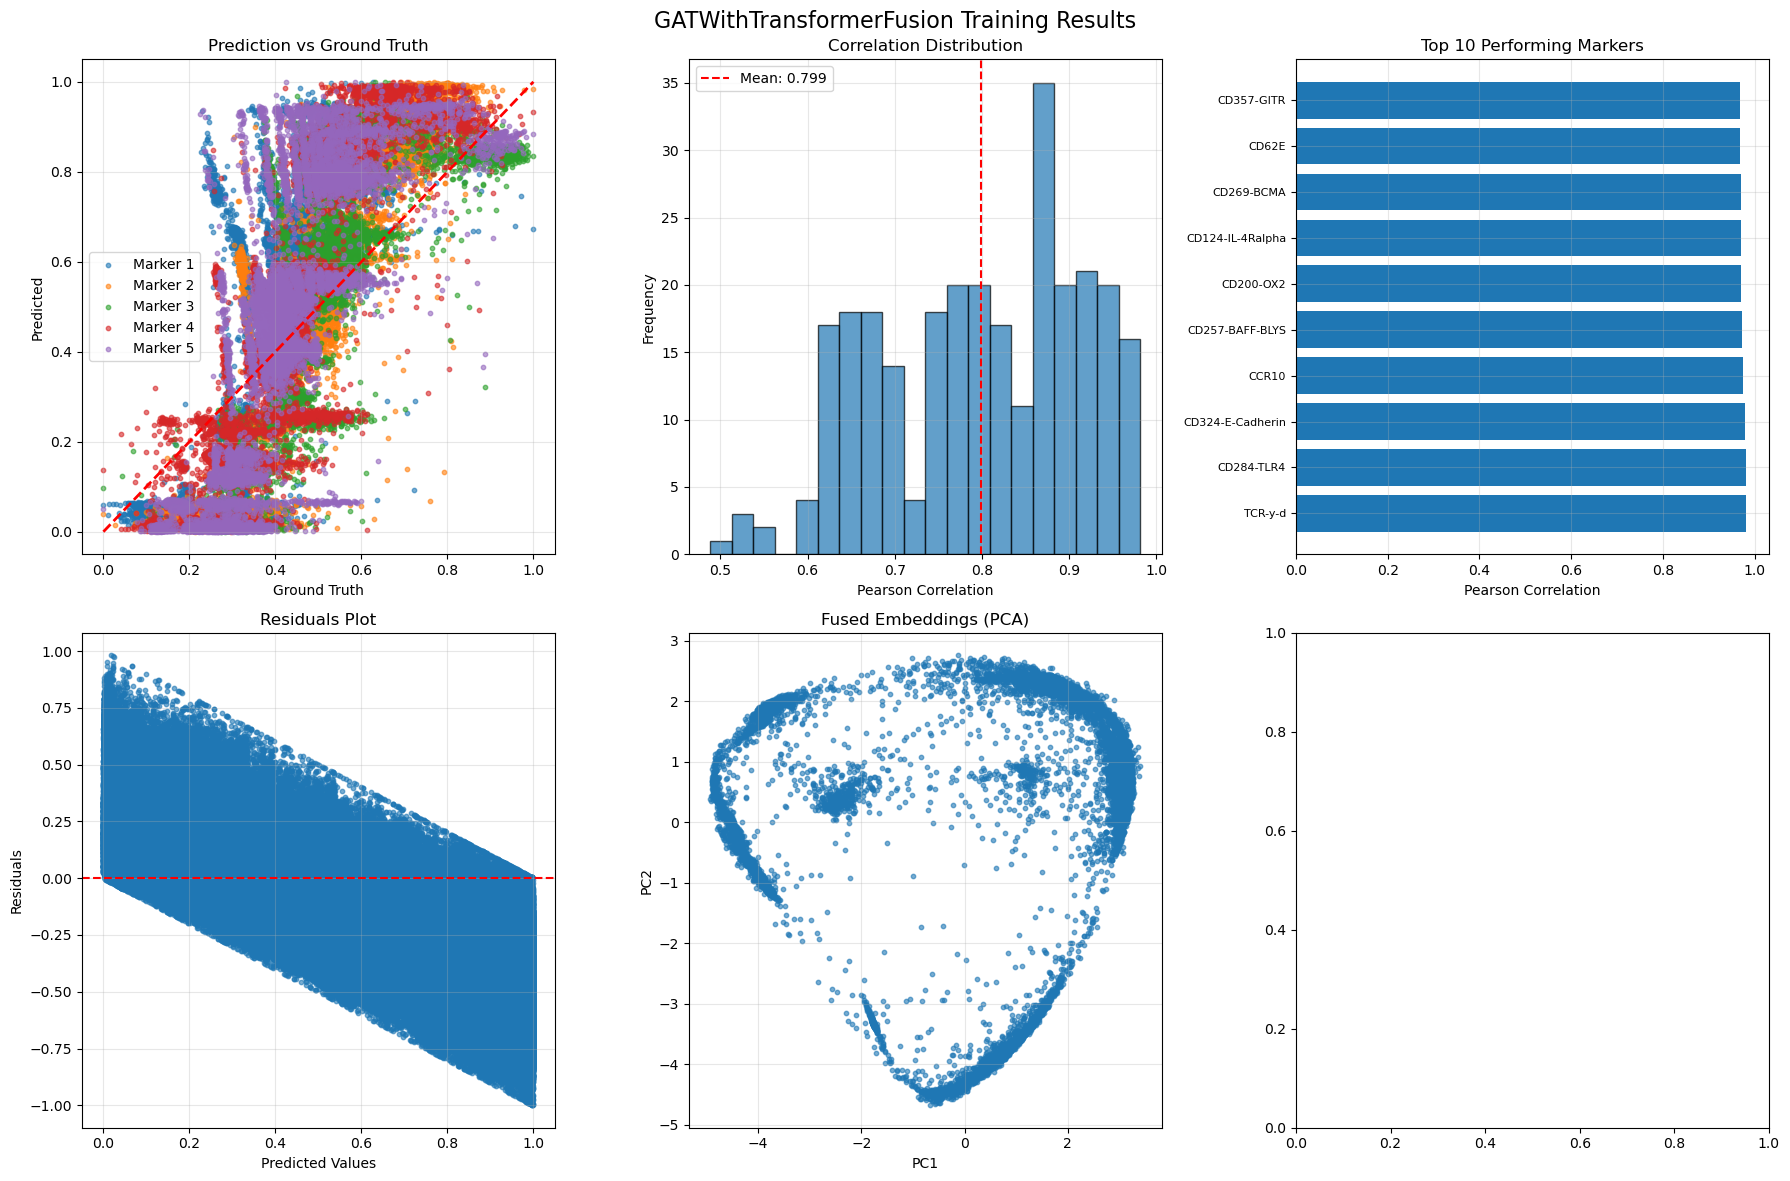

✅ Visualizations complete!


In [9]:
# Create visualizations
import umap
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import numpy as np
print("=== Creating Visualizations ===")

# Calculate total parameters
total_params = sum(p.numel() for p in trained_model.parameters())
print(f"Total model parameters: {total_params:,}")

# Set up plotting
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('GATWithTransformerFusion Training Results', fontsize=16)

# 1. Prediction vs Ground Truth scatter plot (sample of markers)
ax1 = axes[0, 0]
sample_markers = min(5, y_true.shape[1])
for i in range(sample_markers):
    ax1.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, s=10, label=f'Marker {i+1}')
ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
ax1.set_xlabel('Ground Truth')
ax1.set_ylabel('Predicted')
ax1.set_title('Prediction vs Ground Truth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Correlation distribution
ax2 = axes[0, 1]
ax2.hist(pearson_corrs, bins=20, alpha=0.7, edgecolor='black')
ax2.axvline(mean_pearson, color='red', linestyle='--', label=f'Mean: {mean_pearson:.3f}')
ax2.set_xlabel('Pearson Correlation')
ax2.set_ylabel('Frequency')
ax2.set_title('Correlation Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Top performing markers
ax3 = axes[0, 2]
if len(pearson_corrs) > 0:
    top_10_markers = corr_df.nlargest(10, 'pearson')
    ax3.barh(range(len(top_10_markers)), top_10_markers['pearson'])
    ax3.set_yticks(range(len(top_10_markers)))
    ax3.set_yticklabels(top_10_markers['marker'], fontsize=8)
    ax3.set_xlabel('Pearson Correlation')
    ax3.set_title('Top 10 Performing Markers')
    ax3.grid(True, alpha=0.3)

# 4. Residuals plot
ax4 = axes[1, 0]
residuals = y_true - y_pred
ax4.scatter(y_pred, residuals, alpha=0.6, s=10)
ax4.axhline(y=0, color='red', linestyle='--')
ax4.set_xlabel('Predicted Values')
ax4.set_ylabel('Residuals')
ax4.set_title('Residuals Plot')
ax4.grid(True, alpha=0.3)

# 5. Fused embeddings visualization (PCA)
ax5 = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
fused_embeddings_2d = pca.fit_transform(test_fused_embeddings[test_mask].cpu().numpy())
ax5.scatter(fused_embeddings_2d[:, 0], fused_embeddings_2d[:, 1], alpha=0.6, s=10)
ax5.set_xlabel('PC1')
ax5.set_ylabel('PC2')
ax5.set_title('Fused Embeddings (PCA)')
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")


## 7.1 UMAP visuals

In [10]:
# Import required libraries
import umap
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import numpy as np
import matplotlib.pyplot as plt

print("=== Creating UMAP Visualizations ===")

adt_marker_names = [
    'CD357-GITR', 'CD200-OX2'
]

for i, marker_name in enumerate(adt_marker_names[:predictions_np.shape[1]]):
    adt_adata.obs[f'predicted_{marker_name}'] = predictions_np[:, i]

# Normalizing to median total counts
sc.pp.normalize_total(adt_adata)
# Logarithmize the data
sc.pp.log1p(adt_adata)

sc.pp.neighbors(adt_adata)

sc.tl.umap(adt_adata)

sc.pl.umap(
    adt_adata,
    color=["CD357-GITR","predicted_CD357-GITR"],
    # Setting a smaller point size to get prevent overlap
    size=2,
)


=== Creating UMAP Visualizations ===


NameError: name 'predictions_np' is not defined

In [25]:
adt_adata.to_df()

,CD1a,CD1c,CD2,CD3,CD4,CD5,CD7,CD8,CD10,CD11b,...,CD133,C5L2,CD62L,CD1d,CD35,integrin-beta7,VEGFR-3-FLT-4,CD340-erbB2-HER-2,CD88-C5aR,CD274-B7-H1-PD-L1
GSM5613744_2019-07-01-count-1_X2019.07.01.count.1.AAACCCAAGACTCTTG,0.345161,1.458089,0.708303,1.118770,0.893129,0.601270,1.049064,1.782821,0.481392,1.504932,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
GSM5613744_2019-07-01-count-1_X2019.07.01.count.1.AAACCCACAAATGGCG,0.155867,1.160876,0.290685,1.049206,0.854147,0.290685,0.611588,1.714541,0.155867,1.475547,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
GSM5613744_2019-07-01-count-1_X2019.07.01.count.1.AAACCCACACACACGC,0.320889,0.646080,0.320889,0.605613,0.425068,0.140927,0.722409,1.230067,0.140927,1.008112,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
GSM5613744_2019-07-01-count-1_X2019.07.01.count.1.AAACCCAGTACTAGCT,0.177262,1.411741,0.000000,1.312434,0.936700,0.574236,1.009960,1.544350,0.177262,1.584913,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
GSM5613744_2019-07-01-count-1_X2019.07.01.count.1.AAACCCAGTAGACGTG,0.000000,1.172282,0.000000,1.121715,1.068454,0.276479,1.012195,1.781107,0.147764,1.172282,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM5613790_2021-03-09-Z-1-3_X2021.03.09.Z.1.3.TTTGGAGTCGATACAC,0.000000,0.000000,0.796985,1.038196,0.458710,0.846165,0.458710,1.133510,0.000000,0.286819,...,0.0,0.0,0.286819,0.0,0.458710,0.796985,0.0,0.0,0.667618,0.0
GSM5613790_2021-03-09-Z-1-3_X2021.03.09.Z.1.3.TTTGGAGTCTCCGAAA,0.000000,0.292928,0.000000,0.000000,0.467269,0.292928,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.749774,0.0,0.0,0.467269,0.0
GSM5613790_2021-03-09-Z-1-3_X2021.03.09.Z.1.3.TTTGTTGAGTAACAGT,0.000000,0.537901,0.261523,0.423566,0.624798,0.261523,0.261523,0.261523,0.000000,0.000000,...,0.0,0.0,1.100484,0.0,0.910571,0.694112,0.0,0.0,0.751311,0.0
GSM5613790_2021-03-09-Z-1-3_X2021.03.09.Z.1.3.TTTGTTGGTTGCTCAA,0.000000,0.423805,0.000000,0.000000,0.538183,0.000000,0.000000,0.261686,0.000000,0.423805,...,0.0,0.0,0.694443,0.0,0.538183,0.694443,0.0,0.0,0.423805,0.0


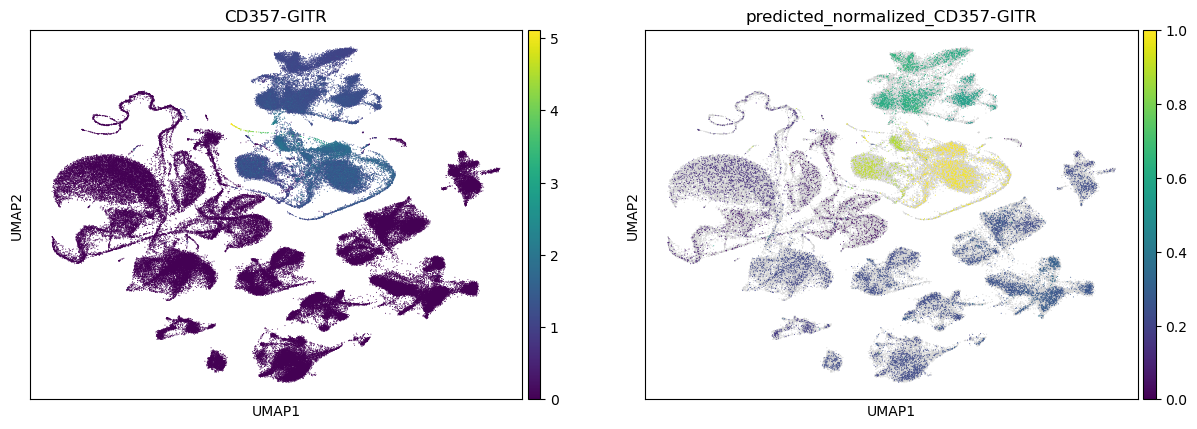

In [23]:
sc.pl.umap(
    adt_adata,
    color=["CD357-GITR","predicted_normalized_CD357-GITR"],
    # Setting a smaller point size to get prevent overlap
    size=2,
)
